In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from IPython.display import display

# --- Scikit-learn imports for building the pipeline ---
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.decomposition import PCA

# --- Classifier imports ---
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --- Project Constants ---
PKL_PATH = "../data/interim/"
INPUT_PKL_FILENAME = "preprocessed.pkl"

TARGET_VARIABLE = 'decision'
SEED = 37  # For reproducibility

In [2]:
# --- Data Loading and Preparation ---
df = pd.read_pickle(PKL_PATH + INPUT_PKL_FILENAME)

# Separate features (X) and the target variable (y).
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE]

In [3]:
# --- Column Grouping for Preprocessing ---
# Define groups of columns based on their data type and intended transformation.
categorical_columns = ['race', 'race_o', 'field']
binary_text_columns = ['gender']
binary_numeric_columns = ['samerace']
numeric_columns = [
    col for col in X.select_dtypes(include=['int64', 'float64']).columns
    if col not in binary_numeric_columns
]

assert len(categorical_columns) + len(binary_text_columns) + len(binary_numeric_columns) + len(numeric_columns) == len(df.columns) - 1

In [4]:
# --- Data Splitting ---
# Split the data into training (85%) and testing (15%) sets.
# 'stratify=y' ensures the target class distribution is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)

In [5]:
# --- Handling Class Imbalance ---
# Calculate the 'scale_pos_weight' value ONLY on the training data to avoid data leakage.
# This value is used by models like XGBoost to give more importance to the minority class.
counts = y_train.value_counts()
count_negative = counts.get(0, 0) # Number of samples with label 0
count_positive = counts.get(1, 0) # Number of samples with label 1

# The standard formula is: (number of negative samples) / (number of positive samples)
if count_positive > 0:
    scale_pos_weight_value = count_negative / count_positive
else:
    # Fallback in the unlikely event of no positive samples in the training set.
    scale_pos_weight_value = 1 

print(f"Negative/Positive class ratio in the training set: {scale_pos_weight_value:.2f}")

Negative/Positive class ratio in the training set: 1.37


In [6]:
# --- Pipeline for standard NUMERIC columns ---
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(
        estimator=BayesianRidge(), 
        max_iter=20, 
        random_state=SEED
    )),
    ('scaler', RobustScaler())
])

# --- Pipeline for CATEGORICAL columns ---
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# --- Pipeline for BINARY columns ---

# Custom transformer to map 'gender' strings ('female'/'male') to integers (0/1).
class GenderMapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        gender_map = {'female': 0, 'male': 1}
        # Apply the map; NaNs will remain as NaN.
        X_copy['gender'] = X_copy['gender'].map(gender_map)
        return X_copy

# Pipeline for the 'gender' column.
binary_text_transformer = Pipeline(steps=[
    ('mapper', GenderMapper()), # Maps 'female'/'male' to 0/1.
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Simple pipeline for 'samerace', which is already numeric but may have NaNs.
binary_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


# --- Combine all preprocessing steps with ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('bin_text', binary_text_transformer, binary_text_columns),
        ('bin_num', binary_numeric_transformer, binary_numeric_columns)
    ],
    remainder='drop' # Drop any columns not specified
)

In [ ]:
# Dictionary of the machine learning models (estimators) to be evaluated.
estimators = {
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=SEED),
    'catboost': CatBoostClassifier(random_state=SEED, verbose=0, allow_writing_files=False)
}

# Dictionary of hyperparameter grids for each model.
param_grids = {
    'hist_gradient_boosting': {
        'model__learning_rate': [0.05],
        'model__max_depth': [8, 9],
        'model__class_weight': ['balanced'],
        'model__max_iter': [180, 200, 220],
        'model__l2_regularization': [1.0]
    },
    # --> Total combinations: 1 * 2 * 1 * 3 * 1 = 6 Combinations

    'catboost': {
        'model__learning_rate': [0.05],
        'model__depth': [6],
        'model__scale_pos_weight': [scale_pos_weight_value],
        'model__subsample': [0.8],
        'model__iterations': [300, 320, 340],
        'model__l2_leaf_reg': [5],
        'model__random_strength': [1.0]
    },
    # --> Total combinations: 1 * 1 * 1 * 1 * 4 * 2 * 1 = 8 Combinations
}

pca_params_to_tune = {
    'pca__n_components': [0.70, 0.80, 0.90, 0.95, 30, 35, 40, 50, None]
}

# Aggiungiamo dinamicamente i parametri della PCA a ogni griglia esistente.
for model_name in param_grids:
    param_grids[model_name].update(pca_params_to_tune)

In [8]:
# Define the scoring metrics to be calculated during cross-validation.
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Specify which score will be used to select the best overall model.
refit_metric = 'accuracy'

### Model Training and Hyperparameter Optimization

In [9]:
# Dictionaries to store the final results.
results = {}
best_estimators = {}    # Dictionary to store the best estimator for each model, already trained.
all_cv_results = {}

# Loop through each model defined in the estimators dictionary.
for name, model in estimators.items():
    model_title = name.replace('_', ' ').title()
    print(f"\n--- Running GridSearchCV for: {model_title} ---")
    start_time = time.time()

    # Create the full pipeline by combining the preprocessor and the model.
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(random_state=SEED)),
        ('model', model)
    ])

    # Define the GridSearchCV object with multiple scoring metrics.
    grid_search = GridSearchCV(
        estimator=full_pipeline,
        param_grid=param_grids[name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
        scoring=scoring_metrics,
        refit=refit_metric,      # The model will be refit on the entire training set using the best ACCURACY score.
        n_jobs=-1,               # Use all available CPU cores.
        verbose=5,
        return_train_score=True  # Essential for analyzing overfitting.
    )

    # Fit the grid search on the training data.
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    execution_time = (end_time - start_time) / 60

    # --- Store the results ---
    # Store the main results for a final summary table.
    results[name] = {
        'best_score_cv': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'execution_time_minutes': execution_time
    }
    # Store the best-performing pipeline (already refitted on the full training data).
    best_estimators[name] = grid_search.best_estimator_
    # Store the complete cross-validation results for detailed analysis.
    all_cv_results[name] = pd.DataFrame(grid_search.cv_results_)
    
    print(f"Best Accuracy (CV) for {model_title}: {grid_search.best_score_:.4f}")
    print(f"Execution time: {execution_time:.2f} minutes")

    # --- Detailed Visualization for the Current Model ---
    
    print(f"\n--- Detailed GridSearchCV Results for {model_title} ---\n")
    
    # Extract the results into a DataFrame.
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Define the columns of interest.
    param_columns = [f'param_{key}' for key in param_grids[name].keys()]
    
    # NOTE: 'test' and 'train' here refer to the internal cross-validation splits.
    score_columns = [
        'mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc',
        'mean_train_accuracy', 'mean_train_f1', 'mean_train_roc_auc',
        f'rank_test_{refit_metric}', 'rank_test_f1'
    ]
    
    # Create the table to be displayed.
    columns_to_show =  score_columns + param_columns
    model_results_table = cv_results_df[columns_to_show].copy()
    model_results_table.rename(columns=lambda x: x.replace('param_model__', ''), inplace=True)
    model_results_table.sort_values(by=f'rank_test_{refit_metric}', inplace=True)
    
    # Display the top-performing hyperparameter combinations.
    display(model_results_table.head(25))
    print("-" * 80)


--- Running GridSearchCV for: Hist Gradient Boosting ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Accuracy (CV) for Hist Gradient Boosting: 0.6665
Execution time: 5.66 minutes

--- Detailed GridSearchCV Results for Hist Gradient Boosting ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_accuracy,rank_test_f1,learning_rate,max_depth,class_weight,max_iter,l2_regularization,param_pca__n_components
17,0.666476,0.606061,0.719498,0.939905,0.930389,0.986471,1,1,0.05,8,balanced,200,1.0,None
8,0.665340,0.605818,0.719188,0.930853,0.920036,0.982260,2,2,0.05,8,balanced,180,1.0,None
26,0.665198,0.603781,0.719486,0.947075,0.938569,0.989692,3,3,0.05,8,balanced,220,1.0,None
44,0.663779,0.600267,0.718061,0.942887,0.933812,0.987948,4,7,0.05,9,balanced,200,1.0,None
35,0.662785,0.600908,0.717891,0.932948,0.922483,0.983912,5,6,0.05,9,balanced,180,1.0,None
43,0.662644,0.602072,0.713708,0.942887,0.933811,0.987599,6,4,0.05,9,balanced,200,1.0,50
15,0.662360,0.599802,0.710591,0.932522,0.922065,0.983229,7,8,0.05,8,balanced,200,1.0,40
53,0.662218,0.597369,0.718609,0.951370,0.943514,0.991004,8,12,0.05,9,balanced,220,1.0,None
34,0.662075,0.602064,0.712896,0.932877,0.922316,0.983403,9,5,0.05,9,balanced,180,1.0,50
42,0.661933,0.598114,0.713265,0.934829,0.924668,0.985191,10,10,0.05,9,balanced,200,1.0,40


--------------------------------------------------------------------------------

--- Running GridSearchCV for: Catboost ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Accuracy (CV) for Catboost: 0.6646
Execution time: 4.03 minutes

--- Detailed GridSearchCV Results for Catboost ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_accuracy,rank_test_f1,learning_rate,depth,scale_pos_weight,subsample,iterations,l2_leaf_reg,random_strength,param_pca__n_components
26,0.664630,0.605737,0.720076,0.893476,0.877264,0.961948,1,4,0.05,6,1.374579,0.8,340,5,1.0,None
17,0.664629,0.606599,0.719747,0.886234,0.868912,0.956753,2,1,0.05,6,1.374579,0.8,320,5,1.0,None
8,0.663494,0.605908,0.719711,0.878212,0.859752,0.951058,3,2,0.05,6,1.374579,0.8,300,5,1.0,None
25,0.662785,0.603380,0.721189,0.893689,0.877704,0.961855,4,7,0.05,6,1.374579,0.8,340,5,1.0,50
24,0.661080,0.599771,0.717682,0.887300,0.870482,0.958778,5,12,0.05,6,1.374579,0.8,340,5,1.0,40
16,0.660797,0.602696,0.719872,0.885702,0.868652,0.956777,6,8,0.05,6,1.374579,0.8,320,5,1.0,50
12,0.660512,0.605760,0.713159,0.880555,0.862667,0.952764,7,3,0.05,6,1.374579,0.8,320,5,1.0,0.95
21,0.660228,0.605473,0.713615,0.887761,0.870816,0.957959,8,5,0.05,6,1.374579,0.8,340,5,1.0,0.95
6,0.659376,0.599913,0.716575,0.871078,0.851827,0.947469,9,11,0.05,6,1.374579,0.8,300,5,1.0,40
15,0.659234,0.599108,0.716969,0.881194,0.863517,0.953801,10,13,0.05,6,1.374579,0.8,320,5,1.0,40


--------------------------------------------------------------------------------


### Riepilogo e Confronto dei Modelli

In [10]:
summary_data = []   # List to hold summary data for each model.

# Iterate over the saved cross-validation results.
for name, cv_results_df in all_cv_results.items():
    
    # Find the index of the best-performing model based on the refit metric ('accuracy').
    # .idxmin() is used because lower rank is better.
    best_model_index = cv_results_df[f'rank_test_{refit_metric}'].idxmin()
    
    # Extract the full row (as a Series) containing all data for that best model.
    best_result_series = cv_results_df.loc[best_model_index]
    
    # Append a dictionary with the key information to our summary list.
    summary_data.append({
        'model': name.replace('_', ' ').title(),
        'mean_test_accuracy': best_result_series['mean_test_accuracy'],
        'mean_test_f1': best_result_series['mean_test_f1'],
        'mean_test_roc_auc': best_result_series['mean_test_roc_auc'],
        'mean_train_accuracy': best_result_series['mean_train_accuracy'],
        'mean_train_f1': best_result_series['mean_train_f1'],
        'mean_train_roc_auc': best_result_series['mean_train_roc_auc'],
        'execution_time_minutes': results[name]['execution_time_minutes']
    })

# Create the final comparison DataFrame from the list of dictionaries.
comparison_df = pd.DataFrame(summary_data)
# Use the model name as the table index.
comparison_df.set_index('model', inplace=True)

# Sort the table by the most important metric (Test Accuracy) ---
comparison_df = comparison_df.sort_values(by='mean_test_accuracy', ascending=False)

# Create a numeric copy for plotting BEFORE formatting ---
comparison_numeric = comparison_df.copy()

# Apply formatting for better readability in the displayed table.
float_cols = [col for col in comparison_df.columns if 'time' not in col]
for col in float_cols:
    comparison_df[col] = comparison_df[col].map('{:.4f}'.format)
comparison_df['execution_time_minutes'] = comparison_df['execution_time_minutes'].map('{:.2f}'.format)

# Display the final comparison table.
print("Model comparison table sorted by Test Accuracy (CV):")
display(comparison_df)

Model comparison table sorted by Test Accuracy (CV):


,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,execution_time_minutes
model,,,,,,,
Hist Gradient Boosting,0.6665,0.6061,0.7195,0.9399,0.9304,0.9865,5.66
Catboost,0.6646,0.6057,0.7201,0.8935,0.8773,0.9619,4.03


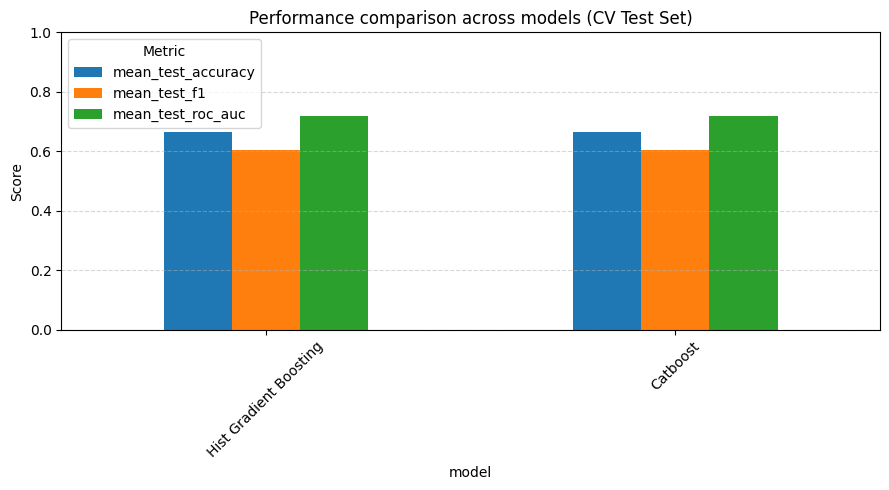

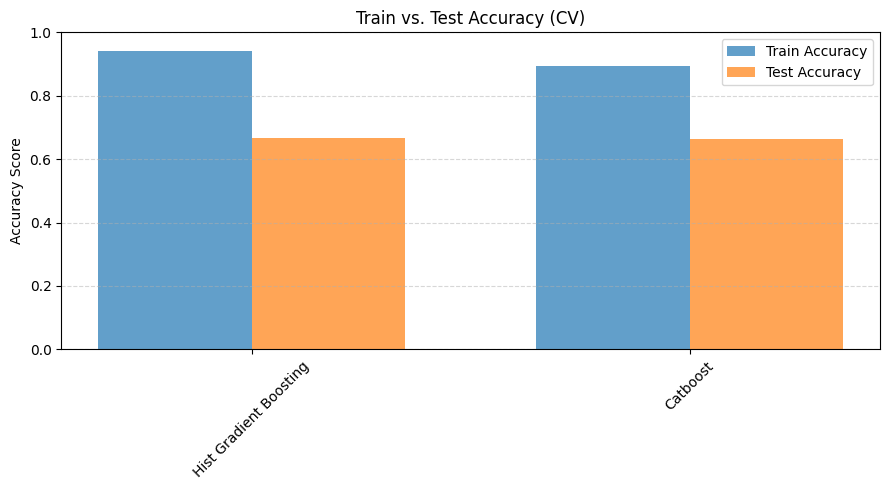

In [11]:
# === Plot 1: Compare Test Metrics: Accuracy, F1, ROC AUC ===
metrics_to_plot = ['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']

# Use the numeric DataFrame for plotting.
comparison_numeric[metrics_to_plot].plot(kind='bar', figsize=(9, 5))
plt.title('Performance comparison across models (CV Test Set)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# === Plot 2: Compare Train vs. Test for Accuracy (to check for overfitting) ===
# This plot now uses 'accuracy' to align with the main goal.
plt.figure(figsize=(9, 5))
bar_width = 0.35
indices = np.arange(len(comparison_numeric)) # Use numpy arange for consistent indexing

plt.bar(indices, comparison_numeric['mean_train_accuracy'], width=bar_width, label='Train Accuracy', alpha=0.7)
plt.bar(indices + bar_width, comparison_numeric['mean_test_accuracy'], width=bar_width, label='Test Accuracy', alpha=0.7)

plt.title('Train vs. Test Accuracy (CV)')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.xticks(indices + bar_width / 2, comparison_numeric.index, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### In-depth Comparison Between the Two Best Models


--- Dynamic Selection for Statistical Comparison ---
Model A (Top-ranked by Accuracy): Hist Gradient Boosting
  - CV Accuracy: 0.6665
Model B (Second-ranked by Accuracy): Catboost
  - CV Accuracy: 0.6646

Running comparison with RepeatedStratifiedKFold on the TEST SET...
Comparison complete.

--- Average Scores on Test Set (from resampling) ---
Avg Accuracy Model A (hist_gradient_boosting): 0.6678 +/- 0.0391
Avg Accuracy Model B (catboost): 0.6678 +/- 0.0355
--------------------
Avg F1-Score Model A (hist_gradient_boosting): 0.6120 +/- 0.0458
Avg F1-Score Model B (catboost): 0.6151 +/- 0.0442

--- Visual Inspection of the Normality of Differences ---


NameError: name 'sns' is not defined

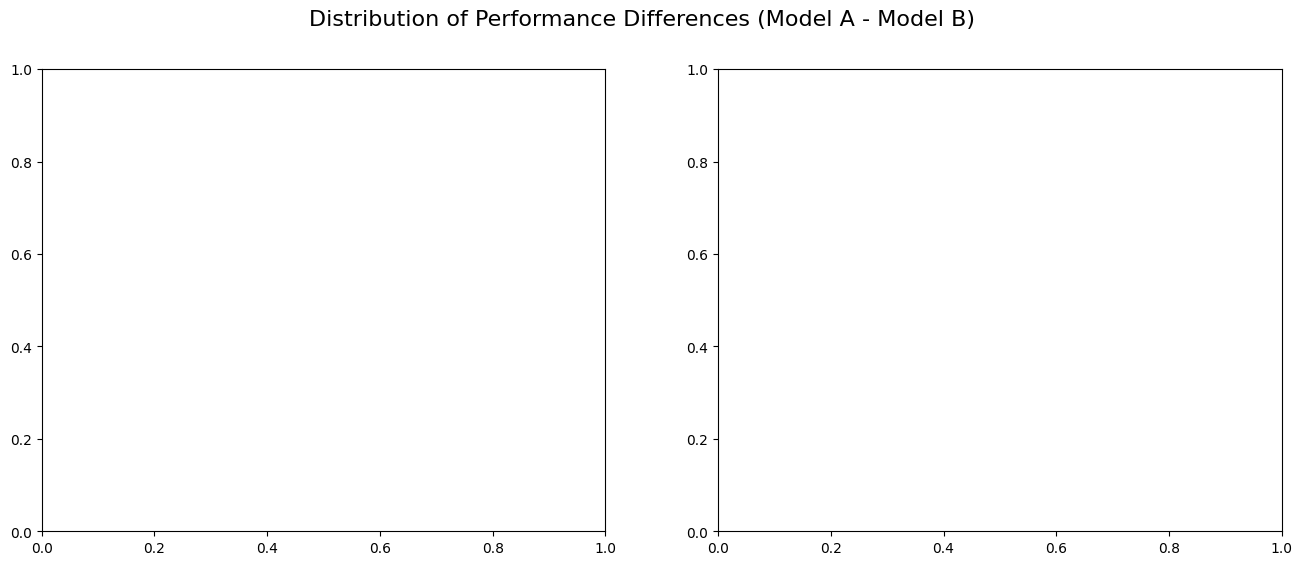

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from scipy import stats

# --- Step 1: Dynamic Selection of the Top Two Models to Compare ---
# Recreate a numeric comparison DataFrame to easily find the best models based on CV scores.
summary_data_numeric = []
for name, cv_results_df in all_cv_results.items():
    best_model_index = cv_results_df[f'rank_test_{refit_metric}'].idxmin()
    best_result_series = cv_results_df.loc[best_model_index]
    summary_data_numeric.append({
        'model': name,
        'mean_test_accuracy': best_result_series['mean_test_accuracy'],
        'mean_test_f1': best_result_series['mean_test_f1']
    })
comparison_df_numeric = pd.DataFrame(summary_data_numeric).set_index('model')

# Check if there are at least two models to compare.
if len(comparison_df_numeric) < 2:
    print("WARNING: Fewer than two models available. Statistical comparison will be skipped.")
else:
    # --- Dynamically find the top two models by accuracy ---
    sorted_models = comparison_df_numeric.sort_values(by='mean_test_accuracy', ascending=False)
    
    # Select the names of the top two models.
    model_a_name = sorted_models.index[0]
    model_b_name = sorted_models.index[1]

    # Retrieve the corresponding trained pipelines from the dictionary.
    model_a = best_estimators[model_a_name]
    model_b = best_estimators[model_b_name]

    print("\n--- Dynamic Selection for Statistical Comparison ---")
    print(f"Model A (Top-ranked by Accuracy): {model_a_name.replace('_', ' ').title()}")
    print(f"  - CV Accuracy: {sorted_models.loc[model_a_name, 'mean_test_accuracy']:.4f}")
    print(f"Model B (Second-ranked by Accuracy): {model_b_name.replace('_', ' ').title()}")
    print(f"  - CV Accuracy: {sorted_models.loc[model_b_name, 'mean_test_accuracy']:.4f}")

    # --- Step 2: Perform Resampling Test on the Hold-out Test Set ---
    # This provides a robust evaluation of how the models generalize to new, unseen data.
    cv_test = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=SEED)
    scores_a_accuracy, scores_b_accuracy = [], []
    scores_a_f1, scores_b_f1 = [], []

    print("\nRunning comparison with RepeatedStratifiedKFold on the TEST SET...")
    for _, test_fold_idx in cv_test.split(X_test, y_test):
        X_fold = X_test.iloc[test_fold_idx]
        y_fold = y_test.iloc[test_fold_idx]

        # Evaluate Model A on the fold
        y_pred_a = model_a.predict(X_fold)
        scores_a_accuracy.append(accuracy_score(y_fold, y_pred_a))
        scores_a_f1.append(f1_score(y_fold, y_pred_a, average='binary'))

        # Evaluate Model B on the fold
        y_pred_b = model_b.predict(X_fold)
        scores_b_accuracy.append(accuracy_score(y_fold, y_pred_b))
        scores_b_f1.append(f1_score(y_fold, y_pred_b, average='binary'))

    print("Comparison complete.")
    
    # --- Step 3: Statistical Analysis ---
    # Calculate the pairwise differences in performance for each fold.
    diff_accuracy = np.array(scores_a_accuracy) - np.array(scores_b_accuracy)
    diff_f1 = np.array(scores_a_f1) - np.array(scores_b_f1)

    print("\n--- Average Scores on Test Set (from resampling) ---")
    print(f"Avg Accuracy Model A ({model_a_name}): {np.mean(scores_a_accuracy):.4f} +/- {np.std(scores_a_accuracy):.4f}")
    print(f"Avg Accuracy Model B ({model_b_name}): {np.mean(scores_b_accuracy):.4f} +/- {np.std(scores_b_accuracy):.4f}")
    print("-" * 20)
    print(f"Avg F1-Score Model A ({model_a_name}): {np.mean(scores_a_f1):.4f} +/- {np.std(scores_a_f1):.4f}")
    print(f"Avg F1-Score Model B ({model_b_name}): {np.mean(scores_b_f1):.4f} +/- {np.std(scores_b_f1):.4f}")
    
    # --- Step 4: Visual Inspection of Difference Distributions ---
    # Check if the differences are normally distributed to inform the choice of statistical test.
    print("\n--- Visual Inspection of the Normality of Differences ---")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Distribution of Performance Differences (Model A - Model B)', fontsize=16)

    sns.histplot(diff_accuracy, kde=True, bins=15, ax=axes[0], color='cornflowerblue')
    axes[0].set_title(f'Distribution of Accuracy Differences')
    axes[0].set_xlabel('Difference in Accuracy')

    sns.histplot(diff_f1, kde=True, bins=15, ax=axes[1], color='salmon')
    axes[1].set_title(f'Distribution of F1-Score Differences')
    axes[1].set_xlabel('Difference in F1-Score')
    plt.show()

    # Q-Q plots provide a more rigorous check for normality.
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Q-Q Plot of Performance Differences', fontsize=16)
    stats.probplot(diff_accuracy, dist="norm", plot=axes[0])
    axes[0].set_title('Q-Q Plot for Accuracy Differences')
    stats.probplot(diff_f1, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot for F1-Score Differences')
    plt.show()

    # --- Step 5: Perform Statistical Tests ---
    # Formally check for normality using the Shapiro-Wilk test.
    shapiro_stat_acc, shapiro_p_acc = stats.shapiro(diff_accuracy)
    shapiro_stat_f1, shapiro_p_f1 = stats.shapiro(diff_f1)
    print("\n--- Normality Test on Differences (Shapiro-Wilk) ---")
    print(f"P-value for Accuracy differences: {shapiro_p_acc:.4f}")
    print(f"P-value for F1-Score differences: {shapiro_p_f1:.4f}")

    # Based on normality, choose the appropriate paired statistical test.
    alpha = 0.05
    # Test for Accuracy
    if shapiro_p_acc > alpha:
        print("\nAccuracy differences appear normal -> Performing paired t-test.")
        stat, p_value = stats.ttest_rel(scores_a_accuracy, scores_b_accuracy)
    else:
        print("\nAccuracy differences do NOT appear normal -> Performing Wilcoxon signed-rank test.")
        stat, p_value = stats.wilcoxon(scores_a_accuracy, scores_b_accuracy, zero_method='zsplit')
    print(f"Test result for Accuracy: Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value < alpha:
        print("-> The difference between models in terms of ACCURACY is statistically significant.")
        mean_diff_acc = np.mean(diff_accuracy)
        if mean_diff_acc > 0:
            # If mean(A-B) > 0, then Model A is better.
            print(f"   - Conclusion: '{model_a_name.replace('_', ' ').title()}' is significantly better.")
        elif mean_diff_acc < 0:
            # If mean(A-B) < 0, then Model B is better.
            print(f"   - Conclusion: '{model_b_name.replace('_', ' ').title()}' is significantly better.")
    else:
        print("-> The difference between models in terms of ACCURACY is NOT statistically significant.")

    # Test for F1-Score
    if shapiro_p_f1 > alpha:
        print("\nF1-score differences appear normal -> Performing paired t-test.")
        stat, p_value = stats.ttest_rel(scores_a_f1, scores_b_f1)
    else:
        print("\nF1-score differences do NOT appear normal -> Performing Wilcoxon signed-rank test.")
        stat, p_value = stats.wilcoxon(scores_a_f1, scores_b_f1, zero_method='zsplit')
    print(f"Test result for F1-Score: Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value < alpha:
        print("-> The difference between models in terms of F1-SCORE is statistically significant.")
        mean_diff_f1 = np.mean(diff_f1)
        if mean_diff_f1 > 0:
            # If mean(A-B) > 0, then Model A is better.
            print(f"   - Conclusion: '{model_a_name.replace('_', ' ').title()}' is significantly better.")
        elif mean_diff_f1 < 0:
            # If mean(A-B) < 0, then Model B is better.
            print(f"   - Conclusion: '{model_b_name.replace('_', ' ').title()}' is significantly better.")
    else:
        print("-> The difference between models in terms of F1-SCORE is NOT statistically significant.")

    # --- Step 6: Final Boxplot Visualization ---
    # Provide a clear visual summary of the performance distributions.
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    labels = [ model_a_name.replace('_', ' ').title(), model_b_name.replace('_', ' ').title() ]

    sns.boxplot(data=[scores_a_accuracy, scores_b_accuracy], ax=axes[0], palette="Set2")
    axes[0].set_title("Distribution of Accuracy on the Test Set")
    axes[0].set_ylabel("Accuracy Score")
    axes[0].set_xticks([0, 1]) 
    axes[0].set_xticklabels(labels, rotation=10)

    sns.boxplot(data=[scores_a_f1, scores_b_f1], ax=axes[1], palette="Set2")
    axes[1].set_title("Distribution of F1-Scores on the Test Set")
    axes[1].set_ylabel("F1-Score")
    axes[1].set_xticks([0, 1]) 
    axes[1].set_xticklabels(labels, rotation=10)

    plt.suptitle("Model Performance Comparison via Resampling", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Valutazione del Modello Migliore sul Test Set


--- Valutazione Finale del Modello Vincente: Catboost ---
Iperparametri Ottimali: {'model__depth': 6, 'model__iterations': 320, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.05, 'model__random_strength': 1.0, 'model__scale_pos_weight': np.float64(1.3745785569790965), 'model__subsample': 0.8, 'pca__n_components': 59}

Classification Report sul Test Set:
              precision    recall  f1-score   support

No Match (0)       0.71      0.71      0.71       720
   Match (1)       0.60      0.61      0.61       523

    accuracy                           0.67      1243
   macro avg       0.66      0.66      0.66      1243
weighted avg       0.67      0.67      0.67      1243

--- Metriche Finali sul Test Set ---
Accuracy: 0.6677
F1-Score: 0.6063
ROC-AUC Score: 0.7347
-----------------------------------

Matrice di Confusione del Modello Vincente:


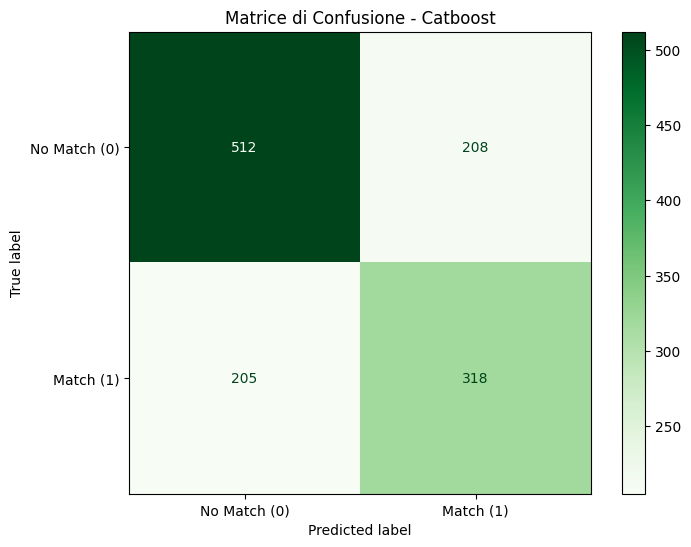

In [ ]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, ConfusionMatrixDisplay

winning_model_name = 'catboost'
best_model_name_formatted = winning_model_name.replace('_', ' ').title()

# Retrieve the best-performing pipeline for the winning model from the 'best_estimators' dictionary.
# This object has already been trained on the full training set with its optimal hyperparameters.
winning_model = best_estimators[winning_model_name]

print(f"\n--- Final Evaluation of the Winning Model: {best_model_name_formatted} ---")
# Print the optimal hyperparameters found during the GridSearchCV.
print(f"Optimal Hyperparameters: {results[winning_model_name]['best_params']}")

# --- Predictions on the Test Set ---
# Use the winning model to make predictions on the hold-out test set (data it has never seen before).
y_pred_test = winning_model.predict(X_test)
# Calculate the probabilities of the positive class, which are required for the ROC-AUC score.
y_proba_test = winning_model.predict_proba(X_test)[:, 1]

# --- Reports and Metrics on the Test Set ---
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['No Match (0)', 'Match (1)']))

# Display the key performance metrics in a concise summary.
print("--- Final Metrics on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}") 
print(f"F1-Score: {f1_score(y_test, y_pred_test, average='binary'):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_test):.4f}")
print("-" * 35)

# --- Confusion Matrix Visualization ---
# The confusion matrix helps to visualize the model's errors (e.g., false positives and false negatives).
print("\nConfusion Matrix of the Winning Model:")
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    winning_model, 
    X_test, 
    y_test, 
    ax=ax, 
    cmap='Greens',
    values_format='d',  # Format counts as integers.
    display_labels=['No Match (0)', 'Match (1)']
)
ax.set_title(f"Confusion Matrix - {best_model_name_formatted}")
plt.grid(False)
plt.show()